In [1]:
import torch

In [2]:
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

3.3%

100.0%


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw


100.0%


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw




25.8%

100.0%


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw



100.0%

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



In [3]:
print(train_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [4]:
print(test_data)

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [5]:
print(train_data.data.size())

torch.Size([60000, 28, 28])


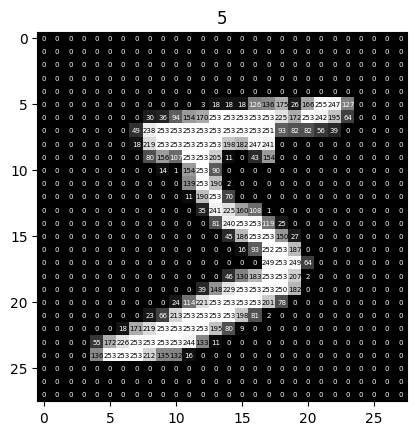

In [6]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.imshow(train_data.data[0], cmap='gray')

for i in range(train_data.data[0].shape[0]):
    for j in range(train_data.data[0].shape[1]):
        c = 1 if train_data.data[0][i, j].item() < 128 else 0
        ax.text(j, i, str(train_data.data[0][i, j].item()), color=(c, c, c), ha='center', va='center',fontsize=5)
        
plt.title('%i' % train_data.targets[0])
plt.show()

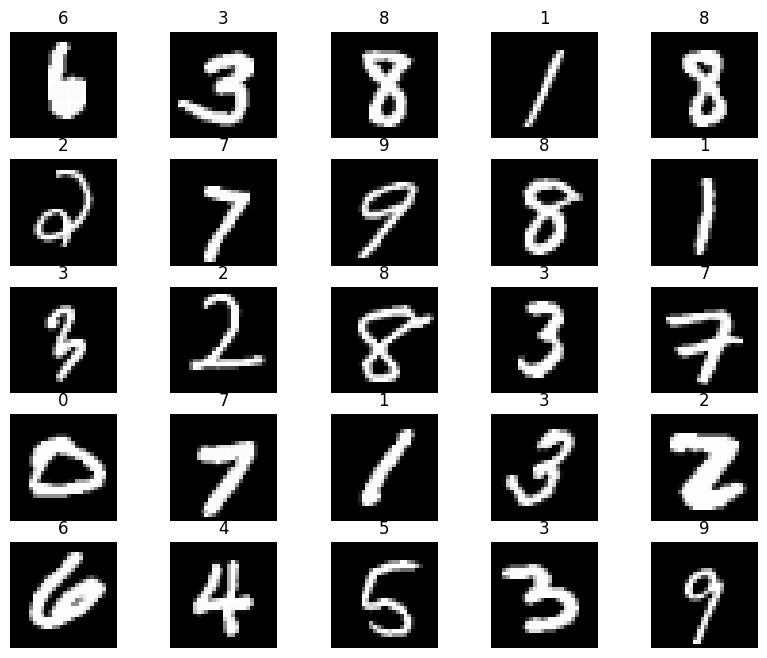

In [7]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [8]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x2162391dd30>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x21639f04640>}

In [9]:
# CNN Model (2 conv layers) 클래스 선언
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),   # 28 x 28 ==> 32 x 32 ==> 28 x 28
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))                  # 28 x 28 ==> 14 x 14
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),   # 14 x 14 ==> 18 x 18 ==> 14 x 14
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))                  # 14 x 14 ==> 7 x 7
        self.fc = torch.nn.Linear(32 * 7 * 7, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)   
        out = self.fc(out)
        return out

In [10]:
model = CNN()

In [11]:
model

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)

In [12]:
learning_rate = 0.01
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
training_epochs = 10

In [14]:
# train my model
total_batch = len(loaders['train'])
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in loaders['train']:
        optimizer.zero_grad()             # gradient clear before computing new gradient for the new batch
        pred = model(X)
        cost = loss_func(pred, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

print('Learning Finished!')

[Epoch:    1] cost = 0.146439031
[Epoch:    2] cost = 0.0548294596
[Epoch:    3] cost = 0.0437672324
[Epoch:    4] cost = 0.0444389358
[Epoch:    5] cost = 0.03999478
[Epoch:    6] cost = 0.0389771163
[Epoch:    7] cost = 0.0373638496
[Epoch:    8] cost = 0.036691267
[Epoch:    9] cost = 0.0375649035
[Epoch:   10] cost = 0.0370435752
Learning Finished!


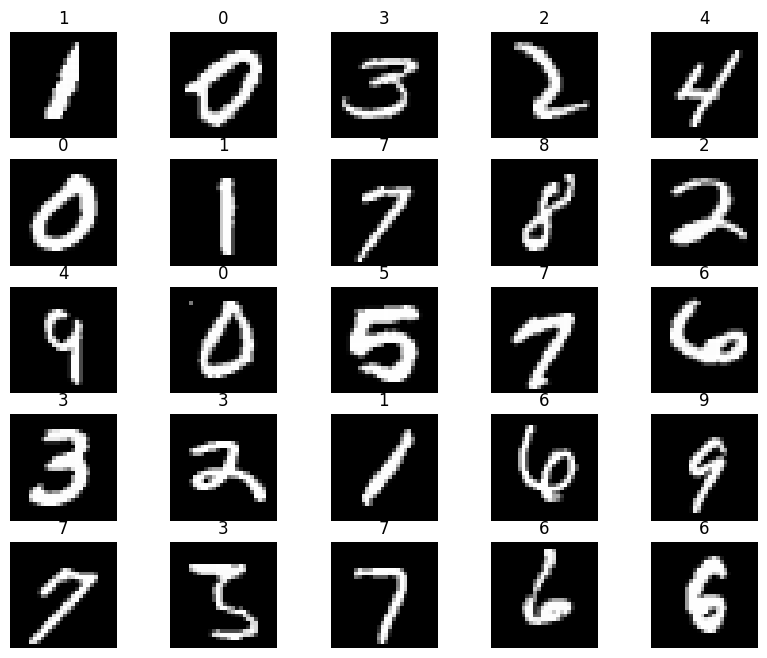

In [15]:
model.eval()
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_data), size=(1,)).item()
    test_output = model(torch.unsqueeze(loaders['test'].dataset[sample_idx][0],dim=0))
    label = torch.argmax(test_output)
    figure.add_subplot(rows, cols, i)
    plt.title(label.numpy())
    plt.axis("off")
    plt.imshow(loaders['test'].dataset[sample_idx][0].squeeze().detach().numpy(), cmap="gray")
plt.show()